In [31]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
#from skimage.transform import resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
import math

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


print(f'shape train set: {x_train.shape}, shape test set: {x_test.shape}')
print(y_train)

shape train set: (50000, 32, 32, 3), shape test set: (10000, 32, 32, 3)
[[19]
 [29]
 [ 0]
 ...
 [ 3]
 [ 7]
 [73]]


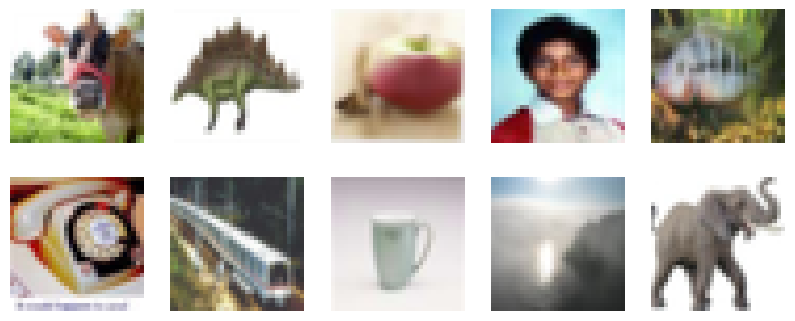

In [33]:
NUM_IMAGES = 10

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(NUM_IMAGES):
    im = x_train[i, :, :, :]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(im)
    ax.axis('off')
plt.show()

In [34]:
class Encoder(keras.Model):
    def __init__(self, num_filters=32, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_filters, kernel_size=3,
                                   activation="relu", strides=2, padding='same', name='enc_conv1')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3,
                                   activation="relu", padding='same', name='enc_conv2')
        self.conv3 = layers.Conv2D(num_filters * 2, kernel_size=3,
                                   activation="relu", padding='same', strides=2, name='enc_conv3')
        self.conv4 = layers.Conv2D(num_filters * 2, kernel_size=3,
                                   activation="relu", padding='same', name='enc_conv4')
        self.conv5 = layers.Conv2D(num_filters * 2, kernel_size=3,
                                   activation="relu", padding='same', strides=2, name='enc_conv5')
        self.flatten = layers.Flatten(name='enc_flatten')
        self.dense = layers.Dense(latent_dim, activation="relu", name='enc_dense')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

encoder = Encoder(num_filters=32, latent_dim=128, name='encoder')
encoder.build((1, 32, 32, 3))
encoder.summary()

class Decoder(keras.Model):
    def __init__(self, num_filters=32, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(16 * num_filters, activation="relu", name='dec_dense')
        self.reshape = layers.Reshape((4, 4, num_filters), name='dec_reshape')
        self.upsam1 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling1')
        self.conv1 = layers.Conv2D(num_filters * 4, kernel_size=3, activation="relu",
                                   padding='same', name='dec_conv1')
        self.upsam2 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling2')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3, activation="relu",
                                   padding='same', name='dec_conv2')
        self.upsam3 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling3')
        self.conv3 = layers.Conv2D(output_channels, kernel_size=3, activation="sigmoid",
                                   padding='same', name='dec_conv3')

    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.upsam1(x)
        x = self.conv1(x)
        x = self.upsam2(x)
        x = self.conv2(x)
        x = self.upsam3(x)
        x = self.conv3(x)
        return x

decoder = Decoder(num_filters=32, output_channels=3, name='decoder')
decoder.build((1, 128))
decoder.summary()

class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


autoencoder = AutoEncoder(encoder, decoder, name='autoencoder')
optimizer = Adam()
autoencoder.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
autoencoder.build((1, 32, 32, 3))
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1 (Conv2D)           multiple                  896       
_________________________________________________________________
enc_conv2 (Conv2D)           multiple                  18496     
_________________________________________________________________
enc_conv3 (Conv2D)           multiple                  36928     
_________________________________________________________________
enc_conv4 (Conv2D)           multiple                  36928     
_________________________________________________________________
enc_conv5 (Conv2D)           multiple                  36928     
_________________________________________________________________
enc_flatten (Flatten)        multiple                  0         
_________________________________________________________________
enc_dense (Dense)            multiple                  1312

In [35]:
# It takes some time to calculate the features for the train and testing sets

def extract_features(images:np.array) -> np.array:
    # Here we use the encoder to return the latent features of the input images
    feats = encoder.predict(images)
    return feats

train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

In [36]:
# This is our similarity measure, the euclidean distance between x and y.
# The closer to 0 the more similar x and y are.

def euclidean_distance(x: np.array, y: np.array) -> float:
    distance = np.sum((x-y)**2)
    return distance

In [37]:
# TODO: Set IDX_SAMPLE to the number of your team

IDX_SAMPLE = 23 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)

# This function retreive the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats, y_train.ravel())
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

In [38]:
def cosine_distance(x:np.array, y:np.array) -> float:
    xNorm = np.linalg.norm(x)
    yNorm = np.linalg.norm(y)
    distance = 1 - (np.dot(x, y)/(math.sqrt(np.dot(xNorm,xNorm))*math.sqrt(np.dot(yNorm,yNorm))))
    return distance

In [39]:
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)

# This function retreive the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES,
                                                    return_distance=True)

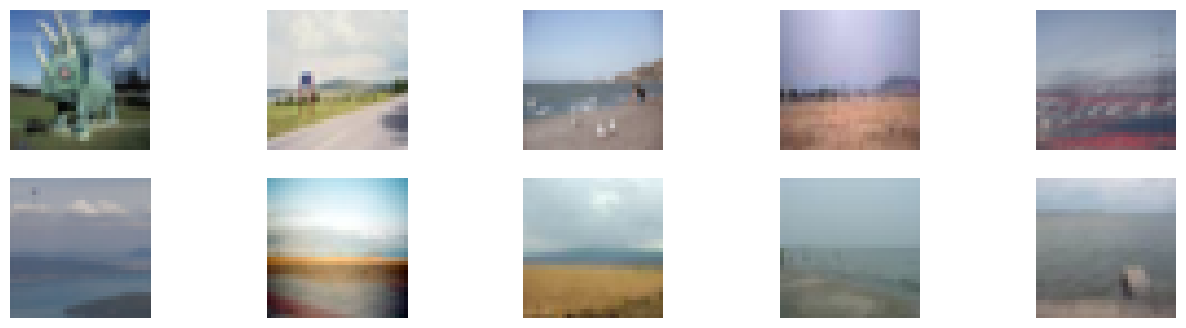

In [42]:
# Task: Show the distances associated with each retrieved image as part of the subtitle (only 2 decimal places)

def visualize_similar_images(retrieved_idx:np.array, retrieved_distances:np.array) -> None:
    fig = plt.figure(figsize=(16, 4))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(2, 5, 1)

    ax.imshow(x_test[IDX_SAMPLE,:,:,:])
    ax.set_title(f'Test image: {LABELS[y_test[IDX_SAMPLE][0]]}')
    ax.axis('off')
    for i in range(NUM_SAMPLES):
        im = x_train[np.squeeze(retrieved_idx)[i], :, :, :]
        ax = fig.add_subplot(2, 5, i + 2)
        ax.imshow(im)
        title = LABELS[y_train[np.squeeze(retrieved_idx)[i]][0]]
        ax.set_title(title + " " + str(round(retrieved_distances[0][i], 2)))
        ax.axis('off')
    plt.show()

visualize_similar_images(retrieved_idx, retrieved_distances)